# Evaluación

Este modulo presenta la evaluación de los modelos seleccionados como mejores,así como la obtención de métricas de negocio y diseñode las salidas para visualización.

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Optional

home_path = os.path.dirname(os.getcwd())
sys.path.append(home_path)

source_path = os.path.join(os.path.dirname(os.getcwd()),'src')
sys.path.append(source_path)

from src.model_management import ClasificadorMora, preprocess

path_etiquetas = os.path.join(home_path, 'data', 'etiquetas.csv')
path_info_clientes = os.path.join(home_path, 'data', 'informacion_clientes.csv')
path_hist_transacciones = os.path.join(home_path, 'data', 'historial_transacciones.csv')

## Modelo 1: XGB

### Métricas del modelo

In [20]:
clasificador1 = ClasificadorMora(
    path_etiquetas,
    path_info_clientes,
    path_hist_transacciones
)

rmse_train,accuracy_train,recall_train,rmse_test,accuracy_test,recall_test = clasificador1.evaluar()
opt_threshold = clasificador1.threshold

Se obtienen las metricas de entrenamiento:
   - RMSE: 0.40767378707327584
   - Accuracy: 0.8338020833333334
   - recall: 0.4268895691076054

 Se obtienen las metricas de prueba:
   - RMSE: 0.4128155358833612
   - Accuracy: 0.8295833333333333
   - recall: 0.3930635838150289


### Evaluando para diferentes cortes según deciles




In [21]:
df_metricas_deciles = pd.DataFrame({
    "p":[],
    "rmse_train":[],
    "accuracy_train":[],
    "recall_train":[],
    "rmse_test":[],
    "accuracy_test":[],
    "recall_test":[]
})
df_metricas_deciles.loc[0] = [
        opt_threshold,rmse_train,accuracy_train,recall_train,rmse_test,accuracy_test,recall_test
    ]
df_row = 1
for threshold in np.arange(0.1,0.6,0.1):
    rmse_train,accuracy_train,recall_train,rmse_test,accuracy_test,recall_test = clasificador1.evaluar_threshold(threshold, verbose=False)
    df_metricas_deciles.loc[df_row] = [
        threshold,rmse_train,accuracy_train,recall_train,rmse_test,accuracy_test,recall_test
    ]
    df_row += 1

In [22]:
df_metricas_deciles

,p,rmse_train,accuracy_train,recall_train,rmse_test,accuracy_test,recall_test
0,0.44,0.407674,0.833802,0.426890,0.412816,0.829583,0.393064
1,0.10,0.747670,0.440990,0.963033,0.766757,0.412083,0.954721
2,0.20,0.495501,0.754479,0.708265,0.513160,0.736667,0.680154
3,0.30,0.427992,0.816823,0.549093,0.433974,0.811667,0.530829
4,0.40,0.408886,0.832812,0.453497,0.416333,0.826667,0.422929
5,0.50,0.406779,0.834531,0.388510,0.415331,0.827500,0.347784


### Probabilidades por cliente

In [6]:
df_probabilidades = clasificador1.obtener_probabilidades_clientes()
df_probabilidades.head(10)

,deuda,probabilidad
CLIENT_ID,,
29c55f5f-0da7-43ec-ba1b-b60592689825,322249,0.168582
f818136a-138f-4578-a0bb-41605b67e0e5,42635,0.114370
bef609a9-f9c5-4870-be7f-cb20e70f7e92,143225,0.109899
2ba3a218-4792-4672-82c7-4b0953101d41,54798,0.056098
723e61b4-d151-4368-b129-468417fd930c,129689,0.108104
f689cc58-4331-40ba-ae4b-c43e649cb9e8,64875,0.068099
5366b666-0978-4843-9ad0-a23993b94edd,7639,0.063838
92825b72-b828-419b-b2b1-0c4791769558,19149,0.157484
bd9b31c5-e0d6-4555-afab-ed6753d6afb8,2400,0.853594


In [16]:
df_deuda_acumulada = df_probabilidades.sort_values('probabilidad')
df_deuda_acumulada['deuda_acumulada'] = df_deuda_acumulada['deuda'].cumsum()
df_deuda_acumulada['deuda_superior'] = np.max(df_deuda_acumulada['deuda_acumulada']) - df_deuda_acumulada['deuda_acumulada']
df_deuda_acumulada.reset_index(inplace=True)
df_deuda_acumulada.drop(columns=["CLIENT_ID", "deuda"], inplace=True)
df_deuda_acumulada

,probabilidad,deuda_acumulada,deuda_superior
0,0.033113,17670,1220670162
1,0.034656,48117,1220639715
2,0.035150,104539,1220583293
3,0.035389,125180,1220562652
4,0.035421,151282,1220536550
...,...,...,...
23995,0.884761,1220677958,9874
23996,0.891458,1220680458,7374
23997,0.892427,1220682945,4887
23998,0.895244,1220685345,2487


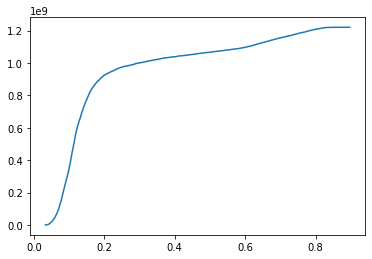

In [17]:
plt.plot(df_deuda_acumulada['probabilidad'],df_deuda_acumulada['deuda_acumulada'])

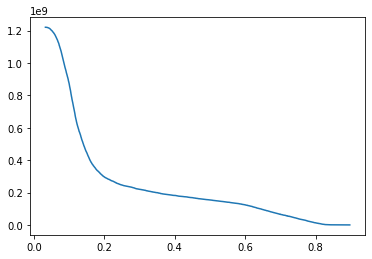

In [18]:
plt.plot(df_deuda_acumulada['probabilidad'],df_deuda_acumulada['deuda_superior'])

## VaR y VaR de grupo

Aproximación teórica basada en Glasserman (2005) y mediante simulación Monte Carlo, basado en P.Robert and Casella (2010)

A tener en cuenta que el VaR presentado utiliza un cuantil del 95% y que el VaR de grupo estadado por

$$ TVaR_{L_i}(1-q) = E(L_i|L>VaR(1-q)) $$

donde $L_i$ es el total de pérdidas asociadas a un grupo dado por que la probabilidade de default es superior a un umbral, es decir $p-j > u_i$

In [52]:
umbrales = df_metricas_deciles['p'].to_numpy()

In [56]:
datos = df_probabilidades.to_numpy()
N = datos.shape[0]
lj = datos[:,0]
pj = datos[:,1]
rs = np.random.RandomState(101)
rs_sim = rs.random(N)
Dj = np.where(rs_sim<=pj,1,0)
xj = lj*Dj
L = np.sum(xj)

In [67]:
perdidas_grupos = {
    f"L{np.round(umbral,2)}":np.sum(np.where(pj>umbral, xj, 0))
    for umbral in umbrales
}

[L] + [perdida for perdida in perdidas_grupos.values()]

[249103126.0,
 109585245.0,
 221921778.0,
 145964983.0,
 129021715.0,
 115308209.0,
 101856983.0]

In [71]:
def obtener_simulacion_perdidas(
    df_probabilidades:pd.DataFrame, 
    umbrales:Optional[np.ndarray] = np.arange(0.1,0.6,0.1)
):
    """
    Función que permite simular las perdidas totales de un portafolio y las perdidas
    por grupos condicinados por superar umbrales de probabilidad de default.

    Args:
    ----------
    df_probabilidades:pd.DataFrame
        DataFrame con las probabilidades de mora para todos los clientes en la base 
        de datos con sus respectivos ID
    umbrales:Optional[np.ndarray] = np.arange(0.1,0.6,0.1)
        Serie de umbrales que separan los grupos.

    Results:
    ---------
    list:
        Lista con las perdidas totales en primera posición y las demás para los
        subgrupos, teniendo tantos elementos como la longitud de umbrales más uno.
    """
    datos = df_probabilidades.to_numpy()
    N = datos.shape[0]
    lj = datos[:,0]
    pj = datos[:,1]
    rs_sim = np.random.random(N)
    Dj = np.where(rs_sim<=pj,1,0)
    xj = lj*Dj
    L = np.sum(xj)

    perdidas_grupos = {
        f"L{np.round(umbral,2)}":np.sum(np.where(pj>umbral, xj, 0))
        for umbral in umbrales
    }

    return [L] + [perdida for perdida in perdidas_grupos.values()]


In [73]:
obtener_simulacion_perdidas(df_probabilidades, umbrales)

[245081408.0,
 109357745.0,
 220195337.0,
 142194589.0,
 125270181.0,
 113332495.0,
 101539853.0]

In [101]:
n = 1000
sim_res = np.array(list(
    map(lambda x: obtener_simulacion_perdidas(df_probabilidades, umbrales),range(n))
))

df_VaRs = pd.DataFrame({
    "p":[],
    "VaR":[],
    "deuda_total":[],
    "VaR_grupo":[]
})
df_row = 0

In [102]:
VaR = np.quantile(sim_res[:,0],0.95)
deuda_total = df_probabilidades['deuda'].sum()
for grupo in np.arange(1,sim_res.shape[1]):
    VaR_grupo = np.sum(
        np.where(sim_res[:,0]>VaR,sim_res[:,grupo],0.0)    
    )/np.sum(
        np.where(sim_res[:,0]>VaR,1.0,0.0)
    )
    df_VaRs.loc[df_row] = [umbrales[grupo-1], VaR, deuda_total, VaR_grupo]
    df_row+= 1

df_VaRs


,p,VaR,deuda_total,VaR_grupo
0,0.44,2.623743e+08,1.220688e+09,1.144106e+08
1,0.10,2.623743e+08,1.220688e+09,2.358921e+08
2,0.20,2.623743e+08,1.220688e+09,1.528537e+08
3,0.30,2.623743e+08,1.220688e+09,1.328268e+08
4,0.40,2.623743e+08,1.220688e+09,1.193935e+08
5,0.50,2.623743e+08,1.220688e+09,1.069096e+08


In [103]:
df_VaRs['deuda_grupo'] = [
    df_probabilidades['deuda'][df_probabilidades['probabilidad'] > umbral].sum()
    for umbral in umbrales
]

df_VaRs['relacion_VaR'] = df_VaRs['VaR_grupo']/df_VaRs['VaR']
df_VaRs['relacion_deuda'] = df_VaRs['deuda_grupo']/df_VaRs['deuda_total']

df_VaRs['relacion_r_d_grupo'] = df_VaRs['VaR_grupo']/df_VaRs['deuda_grupo']

In [104]:
df_VaRs

,p,VaR,deuda_total,VaR_grupo,deuda_grupo,relacion_VaR,relacion_deuda,relacion_d_r_grupo
0,0.44,2.623743e+08,1.220688e+09,1.144106e+08,170134302,0.436059,0.139376,0.672472
1,0.10,2.623743e+08,1.220688e+09,2.358921e+08,877234582,0.899067,0.718640,0.268904
2,0.20,2.623743e+08,1.220688e+09,1.528537e+08,297023808,0.582579,0.243325,0.514618
3,0.30,2.623743e+08,1.220688e+09,1.328268e+08,219950642,0.506249,0.180186,0.603893
4,0.40,2.623743e+08,1.220688e+09,1.193935e+08,181847254,0.455050,0.148971,0.656559
5,0.50,2.623743e+08,1.220688e+09,1.069096e+08,154419916,0.407470,0.126502,0.692330


In [2]:
clasificador1 = ClasificadorMora(
    path_etiquetas,
    path_info_clientes,
    path_hist_transacciones
)
df_informe1 = clasificador1.obtener_informe_modelo()

Se obtienen las metricas de entrenamiento:
   - RMSE: 0.40767378707327584
   - Accuracy: 0.8338020833333334
   - recall: 0.4268895691076054

 Se obtienen las metricas de prueba:
   - RMSE: 0.4128155358833612
   - Accuracy: 0.8295833333333333
   - recall: 0.3930635838150289


In [3]:
df_informe1

,p,rmse_train,accuracy_train,recall_train,rmse_test,accuracy_test,recall_test,VaR,deuda_total,VaR_grupo,deuda_grupo,relacion_VaR,relacion_deuda,relacion_r_d_grupo
0,0.44,0.407674,0.833802,0.426890,0.412816,0.829583,0.393064,261647331.3,1.220688e+09,1.141700e+08,170134302,0.436351,0.139376,0.671058
1,0.10,0.747670,0.440990,0.963033,0.766757,0.412083,0.954721,261647331.3,1.220688e+09,2.352870e+08,877234582,0.899252,0.718640,0.268214
2,0.20,0.495501,0.754479,0.708265,0.513160,0.736667,0.680154,261647331.3,1.220688e+09,1.527358e+08,297023808,0.583747,0.243325,0.514221
3,0.30,0.427992,0.816823,0.549093,0.433974,0.811667,0.530829,261647331.3,1.220688e+09,1.330532e+08,219950642,0.508521,0.180186,0.604923
4,0.40,0.408886,0.832812,0.453497,0.416333,0.826667,0.422929,261647331.3,1.220688e+09,1.192552e+08,181847254,0.455786,0.148971,0.655799
5,0.50,0.406779,0.834531,0.388510,0.415331,0.827500,0.347784,261647331.3,1.220688e+09,1.066832e+08,154419916,0.407737,0.126502,0.690864


## Modelo 2: HGB

In [2]:
clasificador2 = ClasificadorMora(
    path_etiquetas,
    path_info_clientes,
    path_hist_transacciones,
    model_type='hgb'
)
df_informe2 = clasificador2.obtener_informe_modelo()
df_informe2

Se obtienen las metricas de entrenamiento:
   - RMSE: 0.4067144780637476
   - Accuracy: 0.8345833333333333
   - recall: 0.4257122674829291

 Se obtienen las metricas de prueba:
   - RMSE: 0.41482928215512144
   - Accuracy: 0.8279166666666666
   - recall: 0.3872832369942196


,p,rmse_train,accuracy_train,recall_train,rmse_test,accuracy_test,recall_test,VaR,deuda_total,VaR_grupo,deuda_grupo,relacion_VaR,relacion_deuda,relacion_r_d_grupo
0,0.45,0.406714,0.834583,0.425712,0.414829,0.827917,0.387283,2.575751e+08,1.220688e+09,1.156873e+08,171481107,0.449140,0.140479,0.674636
1,0.10,0.712244,0.492708,0.962562,0.738805,0.454167,0.924855,2.575751e+08,1.220688e+09,2.231350e+08,749562732,0.866291,0.614049,0.297687
2,0.20,0.487393,0.762448,0.765246,0.515590,0.734167,0.694605,2.575751e+08,1.220688e+09,1.621959e+08,324176375,0.629703,0.265569,0.500332
3,0.30,0.421431,0.822396,0.588651,0.435651,0.810208,0.554913,2.575751e+08,1.220688e+09,1.388579e+08,232632557,0.539097,0.190575,0.596898
4,0.40,0.407354,0.834063,0.468802,0.417333,0.825833,0.434489,2.575751e+08,1.220688e+09,1.228374e+08,187874304,0.476899,0.153909,0.653828
5,0.50,0.407162,0.834219,0.391100,0.415582,0.827292,0.353565,2.575751e+08,1.220688e+09,1.079644e+08,155965793,0.419157,0.127769,0.692231


In [3]:
X = preprocess(path_info_clientes,path_hist_transacciones)
X

array([[ 0.78620775, -0.81190943,  0.25514665, ...,  1.09132051,
        -0.10155599, -1.06475944],
       [-0.67584203,  1.79400401, -0.61159356, ..., -0.91632109,
        -0.10155599,  0.93917928],
       [ 0.32450782,  0.05672838,  0.25514665, ...,  1.09132051,
        -0.10155599, -1.06475944],
       ...,
       [ 0.09365786, -0.05185134,  0.25514665, ...,  1.09132051,
        -0.10155599, -1.06475944],
       [ 1.1709577 , -0.59474998,  0.25514665, ..., -0.91632109,
        -0.10155599,  0.93917928],
       [ 0.70925777,  0.49104729, -1.47833377, ..., -0.91632109,
        -0.10155599,  0.93917928]])

In [7]:
clasificador1.predict(X,threshold=0.2)

(24000,)

## 